<a href="https://colab.research.google.com/github/Pravallika-Myneni/Data_science_pipeline/blob/main/pm_milestone_clustering_ny_gmm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt


In [66]:
df = pd.read_csv('/content/drive/MyDrive/income-mapped-zip-code.csv', index_col = [0])
df.head(2)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Zipcode,Median_Income,Mean_Income,Age Group,Arrest Date,Arrest Key,Ofns Desc,Pd Desc,Perp Race,Perp Sex,Arrest Precinct,Lat,Lon,LatLon
0,10001,96787,166167,<18,3/24/2019,195084931,ROBBERY,"ROBBERY,OPEN AREA UNCLASSIFIED",BLACK,M,14,40.75,-73.99,"(40.75, -73.99)"
1,10001,96787,166167,25-44,7/11/2018,185049784,F.C.A. P.I.N.O.S.,"FUGITIVE,FROM OTHER STATES",WHITE,F,14,40.75,-73.99,"(40.75, -73.99)"


In [67]:
df['Arrest Date'].value_counts()

2/1/2018     1057
1/11/2018    1051
1/24/2018    1028
2/21/2018    1005
1/18/2018     990
             ... 
7/19/2020     162
7/11/2020     159
7/4/2020      152
6/21/2020     149
3/29/2020     148
Name: Arrest Date, Length: 1096, dtype: int64

In [68]:
df['Zipcode'].nunique()

193

In [69]:
zip_value_counts = df['Zipcode'].value_counts()
zip_value_counts

10456    13235
10457    12181
10031    11868
11434    11541
10001    11357
         ...  
11020        5
11021        3
10705        3
11005        3
10803        2
Name: Zipcode, Length: 193, dtype: int64

In [70]:
zip_value_counts[zip_value_counts>100]

10456    13235
10457    12181
10031    11868
11434    11541
10001    11357
         ...  
11425      161
10280      127
11366      126
11040      124
10069      121
Name: Zipcode, Length: 176, dtype: int64

In [71]:
df['Arrest Key'].nunique(), df.shape

(593721, (593721, 14))

In [72]:
df.groupby(['Zipcode', 'Arrest Date']).count()['Arrest Key'].groupby(level = 0).count()

Zipcode
10001    1084
10002    1032
10003     971
10004     300
10007     776
         ... 
11691    1056
11692     789
11693     827
11694     393
11697      27
Name: Arrest Key, Length: 193, dtype: int64

In [9]:
df.columns

Index(['Zipcode', 'Median_Income', 'Mean_Income', 'Age Group', 'Arrest Date',
       'Arrest Key', 'Ofns Desc', 'Pd Desc', 'Perp Race', 'Perp Sex',
       'Arrest Precinct', 'Lat', 'Lon', 'LatLon'],
      dtype='object')

In [10]:
df[['Lat', 'Lon', 'LatLon']]

,Lat,Lon,LatLon
0,40.75,-73.99,"(40.75, -73.99)"
1,40.75,-73.99,"(40.75, -73.99)"
2,40.75,-73.99,"(40.75, -73.99)"
3,40.75,-73.99,"(40.75, -73.99)"
4,40.75,-73.99,"(40.75, -73.99)"
...,...,...,...
593716,40.56,-73.91,"(40.56, -73.91)"
593717,40.57,-73.89,"(40.57, -73.89)"
593718,40.56,-73.92,"(40.56, -73.92)"
593719,40.56,-73.92,"(40.56, -73.92)"


In [11]:
df_ = df.drop(columns = {'LatLon'}).rename(columns =  {col : col.replace(' ', '_') for col in df.columns if col not in ['Lat', 'Lon']})
df_['Arrest_Date'] = pd.to_datetime(df_.Arrest_Date)
df_['week'] = df_['Arrest_Date'].dt.week
df_['day'] = df_['Arrest_Date'].dt.day
df_['month'] = df_['Arrest_Date'].dt.month

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
df_.head(2)

,Zipcode,Median_Income,Mean_Income,Age_Group,Arrest_Date,Arrest_Key,Ofns_Desc,Pd_Desc,Perp_Race,Perp_Sex,Arrest_Precinct,Lat,Lon,week,day,month
0,10001,96787,166167,<18,2019-03-24,195084931,ROBBERY,"ROBBERY,OPEN AREA UNCLASSIFIED",BLACK,M,14,40.75,-73.99,12,24,3
1,10001,96787,166167,25-44,2018-07-11,185049784,F.C.A. P.I.N.O.S.,"FUGITIVE,FROM OTHER STATES",WHITE,F,14,40.75,-73.99,28,11,7


In [13]:
df.columns

Index(['Zipcode', 'Median_Income', 'Mean_Income', 'Age Group', 'Arrest Date',
       'Arrest Key', 'Ofns Desc', 'Pd Desc', 'Perp Race', 'Perp Sex',
       'Arrest Precinct', 'Lat', 'Lon', 'LatLon'],
      dtype='object')

May be before clustering, we can rank the ofns_Desc and use that as one more attribute for clustering..

we can use other attributes as well here

# Clustering into high threat - medium threat and low threat zones

In [14]:
clustering_df = df_.copy()[['Zipcode', 'Arrest_Key', 'Median_Income', 'Mean_Income', ]]
clustering_df['Mean_Income'] = clustering_df['Mean_Income'].apply(lambda x: np.nan if x=='-' else x) 
clustering_df['Median_Income'] = clustering_df['Median_Income'].apply(lambda x: np.nan if x=='-' else x) 
clustering_df_ = clustering_df.dropna(how='any', axis=0)

clustering_df_['Mean_Income'] = clustering_df_['Mean_Income'].astype('str').apply(lambda x: x.replace('+', '')).astype('int')
clustering_df_['Median_Income'] =clustering_df_['Median_Income'].astype('str').apply(lambda x: x.replace('+', '').replace(',', '')).astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [15]:
clustering_df_ = clustering_df_.groupby(['Zipcode']).agg({ 'Arrest_Key' : 'count', 'Mean_Income' : 'mean' ,  'Median_Income' : 'mean',})
#clustering_df_['Zipcode'] = clustering_df_['Zipcode'].astype('str') 
clustering_df_.head(2)

,Arrest_Key,Mean_Income,Median_Income
Zipcode,,,
10001,11357,166167.0,96787.0
10002,4775,70204.0,35607.0


In [16]:
clustering_df_.describe()

,Arrest_Key,Mean_Income,Median_Income
count,185.000000,185.000000,185.000000
mean,3180.491892,116810.005405,80963.421622
std,3026.427757,64077.120718,35692.545369
min,2.000000,40997.000000,23337.000000
25%,760.000000,78544.000000,57266.000000
50%,2291.000000,98170.000000,75476.000000
75%,4729.000000,128778.000000,96787.000000
max,13235.000000,450531.000000,250000.000000


In [17]:
clustering_df_.head(2)

,Arrest_Key,Mean_Income,Median_Income
Zipcode,,,
10001,11357,166167.0,96787.0
10002,4775,70204.0,35607.0


Is there a point to do this.. convert to str then encode it?? For now, assuming no

In [18]:
"""from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

clustering_df_['Zipcode'] = le.fit_transform(clustering_df_['Zipcode'])

clustering_df_.head(2)"""

"from sklearn.preprocessing import LabelEncoder\n\nle = LabelEncoder()\n\nclustering_df_['Zipcode'] = le.fit_transform(clustering_df_['Zipcode'])\n\nclustering_df_.head(2)"

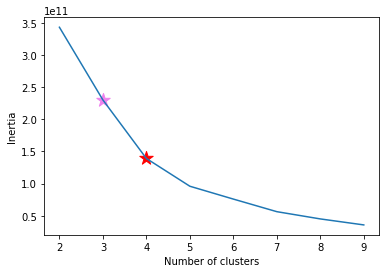

In [79]:
from sklearn.cluster import KMeans
X = np.array(clustering_df_)
inertias = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, init = "k-means++")
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
plt.plot(range(2,10), inertias)
plt.scatter(3,inertias[1], s = 200, c = 'violet', marker='*')
plt.scatter(4,inertias[2], s = 200, c = 'red', marker='*')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

In [80]:
##It gives an idea of how well the objects are classified taking that number of clusters
from sklearn.metrics import silhouette_score
for n_clusters in range(2,10):
    clusterer = KMeans(n_clusters=n_clusters, init = "k-means++")
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_

    score = silhouette_score (X, preds, metric='euclidean', n_jobs=-1)
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.6734739966536474)
For n_clusters = 3, silhouette score is 0.505228286882576)
For n_clusters = 4, silhouette score is 0.4934281414812664)
For n_clusters = 5, silhouette score is 0.4942589623582051)
For n_clusters = 6, silhouette score is 0.4952294792986922)
For n_clusters = 7, silhouette score is 0.4636163900522405)
For n_clusters = 8, silhouette score is 0.4507133421897496)
For n_clusters = 9, silhouette score is 0.4471949762668689)


Silhouetee score is takiing ages to calculate.. try again later?

In [82]:
kmeans = KMeans(n_clusters=3, init = "k-means++")
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
pred = y_kmeans
kmeans = clustering_df_.copy()
kmeans['Label'] = pred
#kmeans = kmeans.reset_index() 

In [83]:
kmeans.shape

(185, 4)

In [84]:
pred.shape

(185,)

In [85]:
kmeans.head(5)

,Arrest_Key,Mean_Income,Median_Income,Label
Zipcode,,,,
10001,11357,166167.0,96787.0,2
10002,4775,70204.0,35607.0,1
10003,4061,211756.0,129981.0,0
10004,423,325028.0,204949.0,0
10007,2088,409624.0,250000.0,0


In [86]:
kmeans[kmeans['Label'] ==0].describe()

,Arrest_Key,Mean_Income,Median_Income,Label
count,24.000000,24.000000,24.000000,24.0
mean,2216.291667,249489.250000,145504.375000,0.0
std,2737.214094,64745.194582,32418.922998,0.0
min,2.000000,189507.000000,75742.000000,0.0
25%,296.500000,210498.750000,130894.750000,0.0
50%,1291.000000,229155.500000,137236.500000,0.0
75%,3434.250000,259187.500000,154978.750000,0.0
max,11252.000000,450531.000000,250000.000000,0.0


In [87]:
kmeans[kmeans['Label'] == 1].describe()

,Arrest_Key,Mean_Income,Median_Income,Label
count,101.000000,101.000000,101.000000,101.0
mean,4311.019802,77687.277228,56519.118812,1.0
std,3154.167392,17115.508096,15340.127478,0.0
min,3.000000,40997.000000,23337.000000,1.0
25%,1582.000000,67230.000000,45555.000000,1.0
50%,3642.000000,80354.000000,57770.000000,1.0
75%,6218.000000,90626.000000,68220.000000,1.0
max,13235.000000,109506.000000,82532.000000,1.0


In [88]:
kmeans[kmeans['Label'] == 2 ].describe()

,Arrest_Key,Mean_Income,Median_Income,Label
count,60.000000,60.000000,60.000000,60.0
mean,1663.116667,129594.900000,96294.950000,2.0
std,1968.214644,26960.549431,14425.434519,0.0
min,3.000000,99441.000000,75476.000000,2.0
25%,441.250000,107090.250000,85223.750000,2.0
50%,976.500000,120702.500000,93527.000000,2.0
75%,2456.500000,147071.250000,103144.750000,2.0
max,11357.000000,193721.000000,132767.000000,2.0


Label which is high threat .... low threat.. based on means may be?

In [89]:
all(kmeans.groupby(['Zipcode'])['Label'].nunique()==1)

True

In [90]:
zip_code_mapping_kmeans = { row['Zipcode']: row['Label']  for i,row in kmeans.reset_index().iterrows()}

## After clustering

[10020, 10115, 10199, 10311, 11359, 11371, 11425, 11430]  -- data is missing for these zip codes

In [91]:
mapping_ = df_[df_['Zipcode'].apply(lambda x: x not  in [10020, 10115, 10199, 10311, 11359, 11371, 11425, 11430])].groupby(['Zipcode'])['Lat', 'Lon'].agg('min').reset_index()
mapping_kmeans = mapping_.copy()
mapping_kmeans["Label"] = mapping_kmeans['Zipcode'].apply(lambda x: zip_code_mapping_kmeans[x])
mapping_kmeans.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Zipcode,Lat,Lon,Label
0,10001,40.75,-74.00,2.0
1,10002,40.71,-73.99,1.0
2,10003,40.73,-73.99,0.0
3,10004,40.70,-74.02,0.0
4,10007,40.71,-74.01,0.0


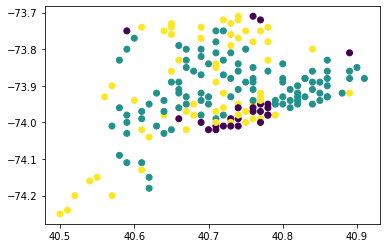

In [92]:
plt.scatter(mapping_kmeans['Lat'], mapping_kmeans['Lon'], c = mapping_kmeans['Label'])

## Gaussian Mixture Models

In [110]:
from sklearn.mixture import GaussianMixture

# define the model
gm = GaussianMixture(n_components=3)
# fit model and predict clusters
yhat = gm.fit_predict(X)
# retrieve unique clusters
clusters = np.unique(yhat)
# create scatter plot for samples from each cluster
plt.figure(figsize=(15,15))
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = np.where(yhat == cluster)
  	# create scatter of these samples
	#plt.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot

<Figure size 1080x1080 with 0 Axes>

In [111]:
gmm_df = clustering_df_.copy()
gmm_df['Label'] = yhat
gmm_df.head(3)

,Arrest_Key,Mean_Income,Median_Income,Label
Zipcode,,,,
10001,11357,166167.0,96787.0,1
10002,4775,70204.0,35607.0,0
10003,4061,211756.0,129981.0,1


In [112]:
gmm_df[gmm_df['Label'] == 0].describe()

,Arrest_Key,Mean_Income,Median_Income,Label
count,66.000000,66.000000,66.000000,66.0
mean,5880.333333,74134.272727,52795.196970,0.0
std,2835.889660,17764.231433,15655.075167,0.0
min,3.000000,40997.000000,23337.000000,0.0
25%,3756.250000,60431.000000,38574.250000,0.0
50%,5777.000000,76648.000000,56014.500000,0.0
75%,7098.750000,85350.250000,64789.000000,0.0
max,13235.000000,109876.000000,84116.000000,0.0


In [113]:
gmm_df[gmm_df['Label'] == 1].describe()

,Arrest_Key,Mean_Income,Median_Income,Label
count,38.000000,38.000000,38.000000,38.0
mean,2561.868421,219628.684211,131051.394737,1.0
std,2882.198956,65462.672097,32701.982253,0.0
min,2.000000,136836.000000,75742.000000,1.0
25%,370.500000,181140.500000,107364.750000,1.0
50%,1860.500000,208401.000000,130615.500000,1.0
75%,3490.000000,240411.750000,139056.250000,1.0
max,11357.000000,450531.000000,250000.000000,1.0


In [114]:
gmm_df[gmm_df['Label'] == 2].describe()

,Arrest_Key,Mean_Income,Median_Income,Label
count,81.000000,81.000000,81.000000,81.0
mean,1270.839506,103346.901235,80417.246914,2.0
std,895.691918,22306.170377,19743.048458,0.0
min,16.000000,43455.000000,29439.000000,2.0
25%,556.000000,89972.000000,68220.000000,2.0
50%,1175.000000,103613.000000,79589.000000,2.0
75%,1793.000000,114854.000000,90871.000000,2.0
max,3266.000000,163186.000000,132767.000000,2.0


In [115]:
zip_code_mapping_gmm = { row['Zipcode']: row['Label']  for i,row in gmm_df.reset_index().iterrows()}

In [116]:
mapping_gmm = mapping_.copy()
mapping_gmm["Label"] = mapping_gmm['Zipcode'].apply(lambda x: zip_code_mapping_gmm[x])
mapping_gmm.head()

,Zipcode,Lat,Lon,Label
0,10001,40.75,-74.00,1.0
1,10002,40.71,-73.99,0.0
2,10003,40.73,-73.99,1.0
3,10004,40.70,-74.02,1.0
4,10007,40.71,-74.01,1.0


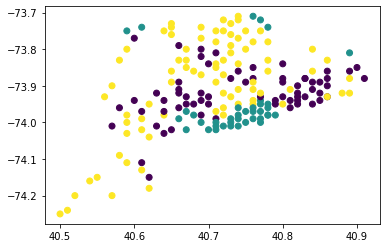

In [117]:
plt.scatter(mapping_gmm['Lat'], mapping_gmm['Lon'], c = mapping_gmm['Label'])

In [118]:
sum(mapping_gmm['Label'] == mapping_kmeans['Label']), sum(mapping_gmm['Label'] != mapping_kmeans['Label'])

(43, 142)

In [122]:
clustering_df_.iloc[0]

Arrest_Key        11357.0
Mean_Income      166167.0
Median_Income     96787.0
Name: 10001, dtype: float64

In [121]:
X[0]

array([ 11357., 166167.,  96787.])

In [124]:
gm.predict_proba([np.array([10000, 200000, 10000])])

array([[1.17611328e-170, 1.00000000e+000, 1.60192981e-120]])